In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import losses

import numpy as np

from multiinstance.nnpu import getPosterior

from sklearn.metrics import brier_score_loss

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from easydict import EasyDict

from multiinstance.data.gaussian_dg import GaussianDG,GaussianMixtureDataGenerator

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

# Data

In [ ]:
dg = GaussianMixtureDataGenerator(100,1,[0.8,0.99],1000,10000)

In [ ]:
x,y = dg.pn_data(10000,dg.alpha)

xTrain,xVal,yTrain,yVal = train_test_split(x, y, test_size=0.33, random_state=42,stratify=y)
del x,y

# Model

In [ ]:
def getModel(input_dim,hdim,n_hidden_layers):
    model = tf.keras.models.Sequential([
        layers.Dense(hdim,input_dim=input_dim,activation=None),
        layers.BatchNormalization(),
        layers.Activation("relu"),
    ])
    for layer_num in range(n_hidden_layers - 1):
        model.add(layers.Dense(hdim,activation=None))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation("relu"))
    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile("adam",loss=tf.keras.losses.BinaryCrossentropy())
    return model

def getSimpleModel(input_dim,hdim,n_hidden_layers):
    model = tf.keras.models.Sequential([
        layers.Dense(hdim,input_dim=input_dim,activation="relu")])
    for layer_num in range(n_hidden_layers - 1):
        model.add(layers.Dense(hdim,activation="relu"))
#         model.add(layers.BatchNormalization())
#         model.add(layers.Activation("relu"))
    model.add(layers.Dense(1,activation="sigmoid"))
    model.compile("adam",loss=tf.keras.losses.BinaryCrossentropy())
    return model

In [ ]:
def qq(model, dg,x,probs=False,sk=False):
    if probs is not False:
        ests = probs
    elif sk:
        ests = model.predict_proba(x)[:,1]
    else:
        ests = model.predict(x)
    true = dg.pn_posterior_cc(x)
    plt.scatter(ests.ravel(),true,label="MAE: {:.3f}".format(np.mean(np.abs(true - ests.ravel()))))
    plt.plot([0,1],[0,1],color="black",label="optimal")
    plt.legend()
    plt.ylabel(r"$p(y|x)$")
    plt.xlabel(r"$\hat{p}(y|x)$")
    plt.show()

In [ ]:
def calib(model,x,y,sk=False,probs=False):
    if probs:
        pred = x
    elif sk:
        pred = model.predict_proba(x)[:,1]
    else:
        pred = model.predict(x)
    prob_true,prob_est = calibration_curve(y,pred,n_bins=10)
    plt.plot(prob_est, prob_true,label="NN (ECE: {:.3f})".format(np.mean(np.abs(prob_true - prob_est))))
    plt.plot([0,1],[0,1],color="black",label="optimal")
    plt.legend()
    plt.xlabel("confidence")
    plt.ylabel("accuracy")
    plt.show()

# Setting 1 : PN data no Platt Correction

In [ ]:
mdl = getModel(xTrain.shape[1],32,10)

In [ ]:
mdl.fit(xTrain,yTrain[:,0],epochs=100,validation_data=(xVal,yVal[:,0]),
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
210/210 [==============================] - 5s 7ms/step - loss: 0.7148 - val_loss: 0.6207
Epoch 2/100
210/210 [==============================] - 1s 6ms/step - loss: 0.6111 - val_loss: 0.5944
Epoch 3/100
210/210 [==============================] - 1s 6ms/step - loss: 0.5855 - val_loss: 0.5558
Epoch 4/100
210/210 [==============================] - 1s 6ms/step - loss: 0.5628 - val_loss: 0.5407
Epoch 5/100
210/210 [==============================] - 1s 6ms/step - loss: 0.5534 - val_loss: 0.5197
Epoch 6/100
210/210 [==============================] - 1s 6ms/step - loss: 0.5401 - val_loss: 0.5137
Epoch 7/100
210/210 [==============================] - 1s 6ms/step - loss: 0.5105 - val_loss: 0.5095
Epoch 8/100
210/210 [==============================] - 1s 6ms/step - loss: 0.4910 - val_loss: 0.5013
Epoch 9/100
210/210 [==============================] - 1s 6ms/step - loss: 0.4904 - val_loss: 0.4991
Epoch 10/100
210/210 [==============================] - 1s 6ms/step - loss: 0.4938 - val_lo

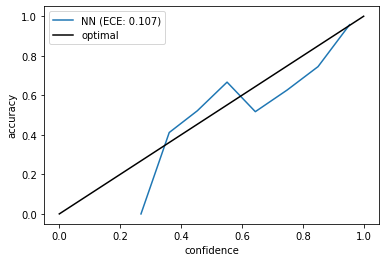

In [ ]:
calib(mdl,xVal,yVal[:,0])

In [ ]:
roc_auc_score(yVal, mdl.predict(xVal))

0.7748471255053238

In [ ]:
roc_auc_score(yVal, dg.pn_posterior_cc(xVal))

0.8314585242380876

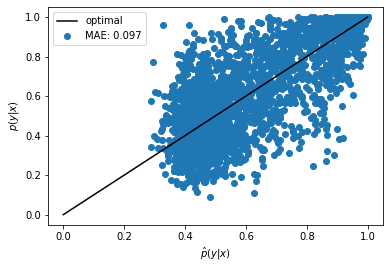

In [ ]:
qq(mdl,dg,xVal)

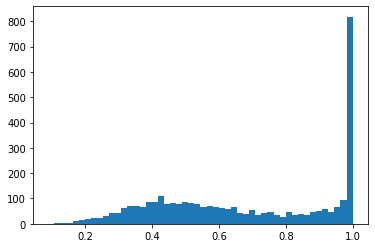

In [ ]:
_= plt.hist(dg.pn_posterior_cc(xVal),bins=50)

# Setting 2 : PN Data Platt

In [ ]:
platt = LogisticRegression().fit(mdl.predict(xTrain),yTrain.ravel())

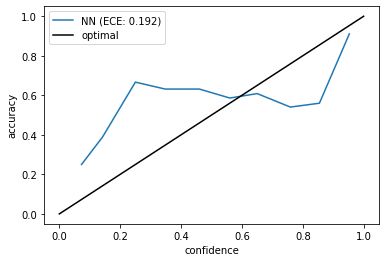

In [ ]:
calib(platt, mdl.predict(xVal),yVal[:,0],sk=True)

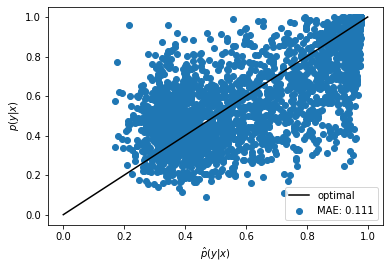

In [ ]:
xs = mdl.predict(xVal)
probs = platt.predict_proba(xs)[:,1]
qq(None,dg,xVal,probs)

Platt's correction doesn't always improve calibration

# Setting 3 : PN Data 2-Step

This should be the same thing as logistic regression

In [ ]:
model2 = tf.keras.models.Sequential([layers.Dense(1,activation="sigmoid")])
model2.compile("adam",loss=tf.keras.losses.BinaryCrossentropy())
model2.fit(mdl.predict(xTrain),yTrain[:,0],epochs=150,validation_data=(mdl.predict(xVal),yVal[:,0]),
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,
                                                        restore_best_weights=True)])

Epoch 1/150
210/210 [==============================] - 1s 2ms/step - loss: 0.6219 - val_loss: 0.6087
Epoch 2/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5996 - val_loss: 0.5968
Epoch 3/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5874 - val_loss: 0.5913
Epoch 4/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5746 - val_loss: 0.5875
Epoch 5/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5738 - val_loss: 0.5840
Epoch 6/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5725 - val_loss: 0.5805
Epoch 7/150
210/210 [==============================] - 0s 2ms/step - loss: 0.5667 - val_loss: 0.5771
Epoch 8/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5582 - val_loss: 0.5736
Epoch 9/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5555 - val_loss: 0.5703
Epoch 10/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5486 - val_lo

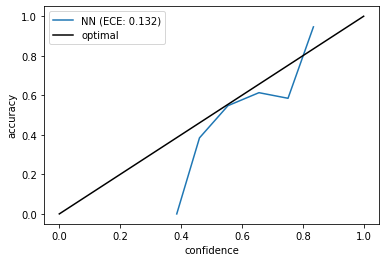

In [ ]:
calib(model2,mdl.predict(xVal),yVal)

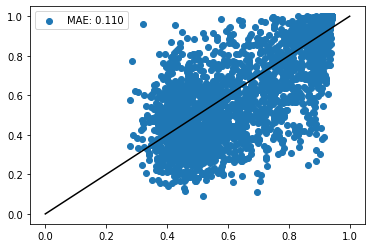

In [ ]:
pred,true = model2.predict(mdl.predict(xVal)).ravel(),dg.pn_posterior_cc(xVal).ravel()
plt.scatter(pred,true,label="MAE: {:.3f}".format(np.mean(np.abs(pred - true))))
plt.plot([0,1],[0,1],color="black")
# qq(model2, dg,model.predict(xVal))
plt.legend()

This model has more capacity than logistic regression

In [ ]:
model2 = tf.keras.models.Sequential([layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1000,activation="relu"),
                                     layers.Dense(1,activation="sigmoid")])
model2.compile("adam",loss=tf.keras.losses.BinaryCrossentropy())
model2.fit(mdl.predict(xTrain),yTrain[:,0],epochs=100,validation_data=(mdl.predict(xVal),yVal[:,0]),
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,
                                                        restore_best_weights=True)])

Epoch 1/100
210/210 [==============================] - 8s 33ms/step - loss: 0.5543 - val_loss: 0.5083
Epoch 2/100
210/210 [==============================] - 7s 31ms/step - loss: 0.4441 - val_loss: 0.6628
Epoch 3/100
210/210 [==============================] - 7s 32ms/step - loss: 0.4479 - val_loss: 0.5029
Epoch 4/100
210/210 [==============================] - 7s 32ms/step - loss: 0.4721 - val_loss: 0.5057
Epoch 5/100
210/210 [==============================] - 7s 31ms/step - loss: 0.4422 - val_loss: 0.5319
Epoch 6/100
210/210 [==============================] - 6s 30ms/step - loss: 0.4389 - val_loss: 0.6334
Epoch 7/100
210/210 [==============================] - 7s 31ms/step - loss: 0.4418 - val_loss: 0.5150
Epoch 8/100
210/210 [==============================] - 7s 32ms/step - loss: 0.4470 - val_loss: 0.5234


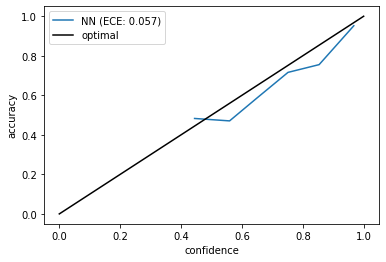

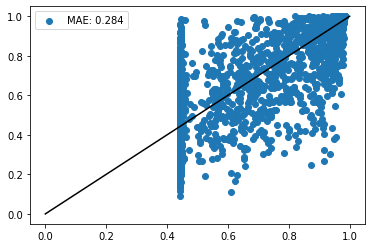

In [ ]:
calib(model2,mdl.predict(xVal),yVal)
pred,true= model2.predict(mdl.predict(xVal)),dg.pn_posterior_cc(xVal)
plt.scatter(pred,true,
            label = "MAE: {:.3f}".format(np.mean(np.abs(pred - true))))
plt.plot([0,1],[0,1],color="black")
plt.legend()

Single dimension: the high capacity platt correction improves calibration


High Dimension Observation

As expected, the high capacity platt correction doesn't lead to better calibration as the high capacity model itself has calibration issues. Calibration is known to be a function of model capacity and regularization

Overall, the high capacity model with no regularization does lead to somewhat poorly calibrated scores. The calibration can be improved through Platt's correction. High capacity calibrators do not improve calibration as well as LR Platt's correction.

# PU Data

True PU Posterior : ECE 0.045

No Transform : ECE 0.107

Platt Corrected Estimated PU Posterior : ECE 0.170

Estimated PU Posterior : ECE 0.203


# Setting 4 : PU data no transform

In [ ]:
xPU,yPU,yPN = dg.pu_data()

In [ ]:
xPUTrain,xPUVal,yPUTrain,yPUVal,yPNTrain,yPNVal = train_test_split(xPU,yPU,yPN,test_size=0.2,stratify=yPU)

In [ ]:
_,net = getPosterior(xPUTrain,yPUTrain,dg.alpha,training_args=EasyDict({"n_units": 20,
                                                                              "n_hidden":10,
                                                                              "dropout_rate":0.1,
                                                                              "maxIter":500,
                                                                              "batch_size":500}))
posteriorEstsNoTransform = net.predict(xPUVal)

### PN Data Calibration and QQ Plots

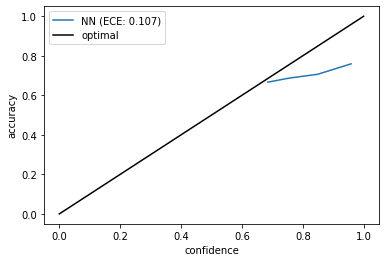

In [ ]:
calib(None,posteriorEstsNoTransform,yPNVal,probs=True)

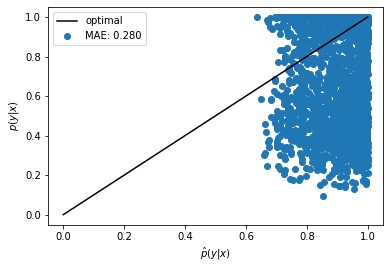

In [ ]:
qq(None,dg,xPUVal,probs=posteriorEstsNoTransform)

# Setting 5 : PU data with True PU Posterior Transform

In [ ]:
_,net = getPosterior(dg.pu_posterior(xPUTrain)[:,None],yPUTrain,dg.alpha,training_args=EasyDict({"n_units": 32,
                                                                              "n_hidden":3,
                                                                              "dropout_rate":0.1,
                                                                              "maxIter":500,
                                                                              "batch_size":256}))
postEstsTrueTau = net.predict(dg.pu_posterior(xPUVal)[:,None])

### PN Data Calib and QQ Plots

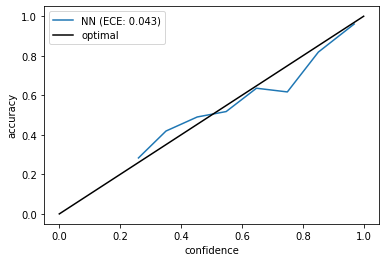

In [ ]:
calib(None,postEstsTrueTau,yPNVal,probs=True)

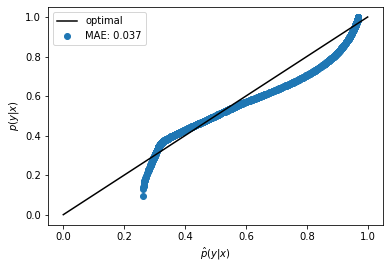

In [ ]:
qq(None,dg,xPUVal,probs=postEstsTrueTau)

# Setting 6 : PU Data with Estimated PU Posterior 

In [ ]:
tauModel = tf.keras.models.Sequential([layers.Dense(25,activation="relu"),
                                       layers.Dense(25,activation="relu"),
                                       layers.Dense(25,activation="relu"),
                                      layers.Dense(1,activation="sigmoid")])
tauModel.compile("adam",loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
tauModel.fit(xPUTrain,yPUTrain[:,0],epochs=100,validation_data=(xPUVal,yPUVal),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
275/275 [==============================] - 1s 2ms/step - loss: 0.4072 - val_loss: 0.3174
Epoch 2/100
275/275 [==============================] - 0s 1ms/step - loss: 0.3018 - val_loss: 0.3121
Epoch 3/100
275/275 [==============================] - 0s 1ms/step - loss: 0.3004 - val_loss: 0.3161
Epoch 4/100
275/275 [==============================] - 0s 1ms/step - loss: 0.3049 - val_loss: 0.3113
Epoch 5/100
275/275 [==============================] - 0s 1ms/step - loss: 0.2831 - val_loss: 0.3143
Epoch 6/100
275/275 [==============================] - 0s 1ms/step - loss: 0.2711 - val_loss: 0.3204
Epoch 7/100
275/275 [==============================] - 0s 1ms/step - loss: 0.2518 - val_loss: 0.3227
Epoch 8/100
275/275 [==============================] - 0s 2ms/step - loss: 0.2383 - val_loss: 0.3391
Epoch 9/100
275/275 [==============================] - 0s 1ms/step - loss: 0.2328 - val_loss: 0.3531


In [ ]:
roc_auc_score(yPUTrain[:,0],
              tauModel.predict(xPUTrain)),roc_auc_score(yPUVal[:,0],
                                                        tauModel.predict(xPUVal))

(0.72765765625, 0.5260012500000001)

### PU Posterior Calibration and QQ Plots

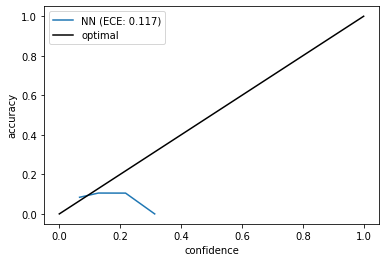

In [ ]:
calib(tauModel,xPUVal,yPUVal)

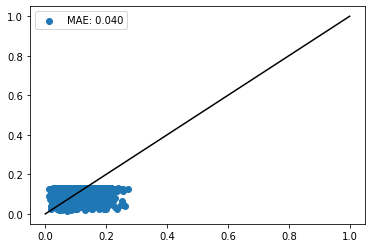

In [ ]:
pred,true = tauModel.predict(xPUVal).ravel(), dg.pu_posterior(xPUVal).ravel()
plt.scatter(pred,true,label="MAE: {:.3f}".format(np.mean(np.abs(pred - true))))
plt.plot([0,1],[0,1],color="black")
plt.legend()

In [ ]:
_,net = getPosterior(tauModel.predict(xPUTrain),yPUTrain,dg.alpha,training_args=EasyDict({"n_units": 32,
                                                                              "n_hidden":2,
                                                                              "dropout_rate":0.1,
                                                                              "maxIter":500,
                                                                              "batch_size":256}),)

posteriorEstsTransform = net.predict(tauModel.predict(xPUVal))

### PN Posterior Calibration and QQ Plot

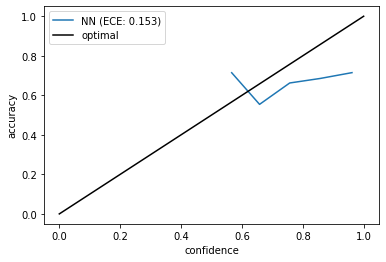

In [ ]:
calib(None,posteriorEstsTransform,yPNVal,probs=True)

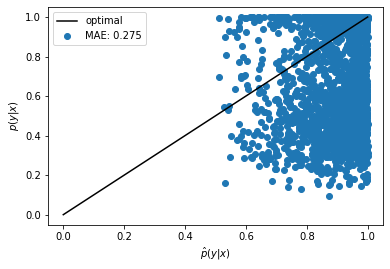

In [ ]:
qq(None,dg,xPUVal,probs=posteriorEstsTransform)

# Calibrate PU Posterior First

### Use LR NN equivalent 

In [ ]:
puPosteriorCalibrator = tf.keras.models.Sequential([layers.Dense(1,activation="sigmoid")])
puPosteriorCalibrator.compile("adam",loss=tf.keras.losses.BinaryCrossentropy())
puPosteriorCalibrator.fit(tauModel.predict(xPUTrain),yPUTrain[:,0],epochs=150,validation_data=(tauModel.predict(xPUVal),
                                                                                               yPUVal[:,0]),
                          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)])


Epoch 1/150
275/275 [==============================] - 1s 1ms/step - loss: 0.6708 - val_loss: 0.5921
Epoch 2/150
275/275 [==============================] - 0s 1ms/step - loss: 0.5700 - val_loss: 0.5114
Epoch 3/150
275/275 [==============================] - 0s 959us/step - loss: 0.5007 - val_loss: 0.4520
Epoch 4/150
275/275 [==============================] - 0s 880us/step - loss: 0.4450 - val_loss: 0.4091
Epoch 5/150
275/275 [==============================] - 0s 931us/step - loss: 0.4036 - val_loss: 0.3781
Epoch 6/150
275/275 [==============================] - 0s 915us/step - loss: 0.3759 - val_loss: 0.3560
Epoch 7/150
275/275 [==============================] - 0s 893us/step - loss: 0.3475 - val_loss: 0.3402
Epoch 8/150
275/275 [==============================] - 0s 906us/step - loss: 0.3403 - val_loss: 0.3289
Epoch 9/150
275/275 [==============================] - 0s 896us/step - loss: 0.3340 - val_loss: 0.3211
Epoch 10/150
275/275 [==============================] - 0s 955us/step - loss:

### PU Posterior QQ Plot

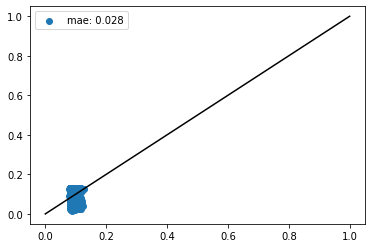

In [ ]:
pred,true = puPosteriorCalibrator.predict(tauModel.predict(xPUVal)).ravel(), dg.pu_posterior(xPUVal).ravel()
plt.scatter(pred,true,label="mae: {:.3f}".format(np.mean(np.abs(true - pred))))
plt.plot([0,1],[0,1],color="black")
plt.legend()

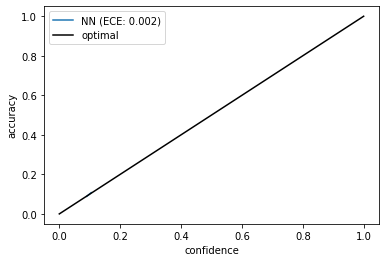

In [ ]:
calib(puPosteriorCalibrator, tauModel.predict(xPUVal),yPUVal)

### PN Posterior QQ Plot

In [ ]:
_,net = getPosterior(puPosteriorCalibrator.predict(tauModel.predict(xPUTrain)),
                         yPUTrain,dg.alpha,training_args=EasyDict({"n_units": 32,
                                                                              "n_hidden":10,
                                                                              "dropout_rate":0.1,
                                                                              "maxIter":500,
                                                                              "batch_size":500}),)


posteriorEstimatesFromCalibratedPUPosterior = net.predict(tauModel.predict(xPUVal))

### PN Posterior Calibration Plot using NN calibrated PU posterior

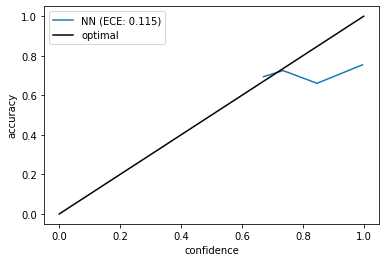

In [ ]:
calib(None,posteriorEstimatesFromCalibratedPUPosterior,yPNVal, probs=True)

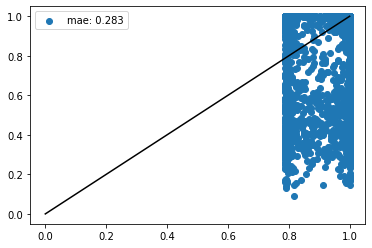

In [ ]:
pred,true = posteriorEstimatesFromCalibratedPUPosterior.ravel(), dg.pn_posterior_cc(xPUVal).ravel()
plt.scatter(pred,true,label="mae: {:.3f}".format(np.mean(np.abs(true - pred))))
plt.plot([0,1],[0,1],color="black")
plt.legend()

### Now try using traditional Platt's Correction

In [ ]:
plattTau = LogisticRegression().fit(tauModel.predict(xPUTrain),yPUTrain[:,0])

### PU Calibration

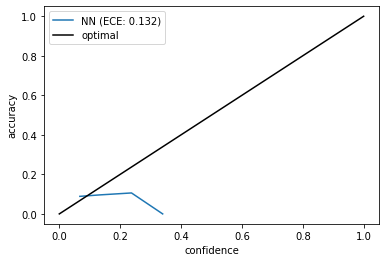

In [ ]:
calib(plattTau, tauModel.predict(xPUVal), yPUVal,sk=True)

### PU Posterior QQ-Plot

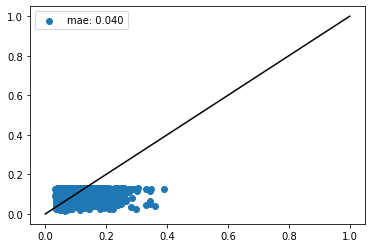

In [ ]:
pred,true = plattTau.predict_proba(tauModel.predict(xPUVal))[:,1].ravel(), dg.pu_posterior(xPUVal).ravel()
plt.scatter(pred,true,label="mae: {:.3f}".format(np.mean(np.abs(pred - true))))
plt.plot([0,1],[0,1],color="black")
plt.legend()

### PN Posterior QQ-Plot

In [ ]:
_,net = getPosterior(plattTau.predict_proba(tauModel.predict(xPUTrain))[:,1][:,None],yPUTrain,dg.alpha,
                                             training_args=EasyDict({"n_units": 20,
                                                                     "n_hidden":3,
                                                                     "dropout_rate":0.1,
                                                                     "maxIter":500,
                                                                     "batch_size":500}),)


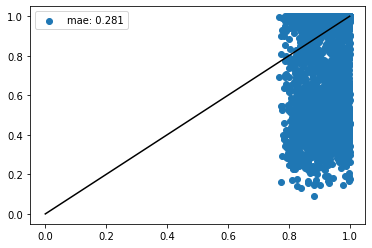

In [ ]:
posteriorFromPlattCorrectedPU = net.predict(plattTau.predict_proba(tauModel.predict(xPUVal))[:,1]).ravel()
true = dg.pn_posterior_cc(xPUVal).ravel()
plt.scatter(posteriorFromPlattCorrectedPU, true, label="mae: {:.3f}".format(np.mean(np.abs(true - posteriorFromPlattCorrectedPU))))
plt.plot([0,1],[0,1],color="black")
plt.legend()

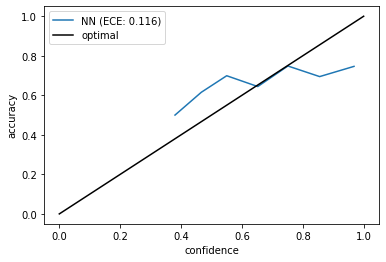

In [ ]:
calib(None, posteriorFromPlattCorrectedPU,yPNVal,probs=True)